In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sklearn
from sklearn import preprocessing, metrics
import numpy as np
import keras as keras
from keras.layers import LSTM, Dense, Dropout, Activation
from keras.models import load_model, Sequential
import time
import random
%matplotlib inline

random.seed(50)

Using TensorFlow backend.


In [2]:
# Can take any input (Will require renaming of chart titles below)
coin = pd.read_csv("btc-usd-max.csv")
coin_name = "BTC"
coin_name_file = "btc"
start_date = "28-04-2013"

In [3]:
def datetime_generator(series, start_date):
    return pd.DatetimeIndex(freq = "D", dayfirst = True, start = start_date, periods = len(series))

def cut_reset_series_with_price_and_date(dataframe, num_data, date_time):
    dataframe = dataframe.set_index(date_time)
    series = dataframe.price
    series = series[-num_data:]
    return series

def cut_reset_series_with_0_and_date(dataframe, num_data, date_time):
    dataframe = dataframe.set_index(date_time)
    series = dataframe[0]
    series = series[-num_data:]
    return series

def combiners(*arg):
    items = list(arg)
    return items

def recommendation(previous_price, predicted_price, margin):
    margined_price_upper = (1 + margin) * previous_price
    margined_price_lower = (1 - margin) * previous_price
    if predicted_price > margined_price_upper:
        return "BUY"
    elif predicted_price < margined_price_lower:
        return "SELL"
    elif margined_price_upper > predicted_price and predicted_price > margined_price_lower:
        return "HOLD"

def csv_generator(columnheaders, indexheaders, data_):
    datatable = pd.DataFrame(columns = [columnheaders], index = indexheaders, data = data_)
    csv_output = datatable.to_csv( coin_name_file + "_output.csv")
    return csv_output

In [4]:
# Main Code
coin_price = coin["price"].values
coin_price_timeindex = datetime_generator(coin_price, start_date)
coin_new_srs = cut_reset_series_with_price_and_date(coin, 200, coin_price_timeindex)

In [5]:
# Scale and Split Data
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
full_data = coin_price.reshape(len(coin_price),1)
full_data = scaler.fit_transform(full_data)

train_size = int(len(full_data) * 0.95)
test_size = len(full_data) - train_size
train, test = full_data[0:train_size,:], full_data[train_size:len(full_data),:]

In [6]:
# dataset to be processed
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

predict_all = np.reshape(np.append([0], full_data), (np.append([0], full_data).shape[0], 1, 1))

In [7]:
# LSTM Model
model = Sequential()

model.add(LSTM(input_shape=(None, 1), units = 20, return_sequences=False, recurrent_dropout = 0.5))

model.add(Dense(units = 1))
model.add(Activation('linear'))

start = time.time()
rmsprop = keras.optimizers.RMSprop(lr=0.000025, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='mse', optimizer=rmsprop, metrics = ['accuracy'])
print ('compilation time : ', time.time() - start)

earlyStopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 0, mode = 'min', verbose = 0)
history = model.fit(trainX, trainY, batch_size=1, epochs=500, shuffle = False, callbacks = [earlyStopping], validation_data = (testX, testY), verbose = 0)
print ('training time : ', time.time() - start)

compilation time :  0.05103635787963867
training time :  198.64951920509338


In [8]:
# Model Prediction and convert to series for plotting
predicted = scaler.inverse_transform(model.predict(predict_all))
predicted = np.reshape(predicted, (predicted.shape[0],))

predicted_df = pd.DataFrame(predicted)
predicted_srs = predicted_df.values
predicted_srs_timeindex = datetime_generator(predicted_srs, start_date)
predicted_new_srs = cut_reset_series_with_0_and_date(predicted_df, 200, predicted_srs_timeindex)

In [9]:
# For Axis Lines for Graph 1 and 2
axis_b = np.min(coin_new_srs) * 0.9
axis_t = np.max(coin_new_srs) * 1.1
axis_l = axis_t - axis_b
axis_int = axis_l/8

coin_axis = coin.assign(y1 = lambda x: axis_b + axis_int)
coin_axis = coin_axis.assign(y2 = lambda x: axis_b + 2 * axis_int)
coin_axis = coin_axis.assign(y3 = lambda x: axis_b + 3 * axis_int)
coin_axis = coin_axis.assign(y4 = lambda x: axis_b + 4 * axis_int)
coin_axis = coin_axis.assign(y5 = lambda x: axis_b + 5 * axis_int)
coin_axis = coin_axis.assign(y6 = lambda x: axis_b + 6 * axis_int)
coin_axis = coin_axis.assign(y7 = lambda x: axis_b + 7 * axis_int)
coin_axis = coin_axis.assign(y8 = lambda x: axis_b + 8 * axis_int)


coin_axis = coin_axis.loc[:, ["y1","y2","y3","y4","y5","y6","y7","y8"]]

coin_price_timeindex2 = datetime_generator(coin_axis, start_date)
coin_axis = coin_axis.set_index(coin_price_timeindex2)
coin_axis = coin_axis[-200:]

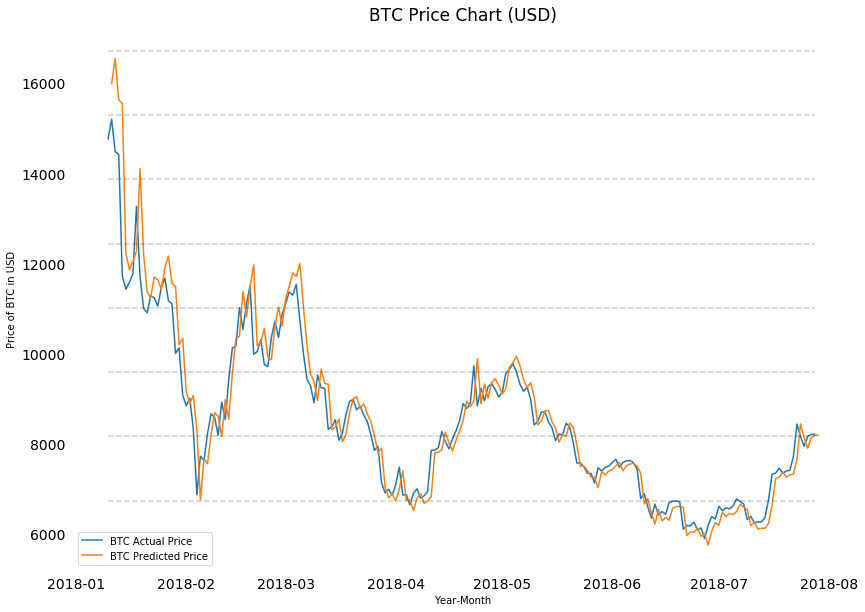

In [10]:
# Plot graph and save
plt.figure(figsize = (14, 10))

ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()

plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)

plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on") 

plt.title( coin_name + " Price Chart (USD)", fontsize = 17)
plt.plot(coin_new_srs)
plt.plot(predicted_new_srs)
plt.plot(coin_axis, "k--", alpha = 0.2)
plt.xlabel("Year-Month")
plt.ylabel("Price of " + coin_name + " in USD")
plt.legend([ coin_name + " Actual Price", coin_name + " Predicted Price"])

plt.savefig( coin_name_file + "_price_chart.png")
plt.show()
plt.close()

In [11]:
# MACD
day_26_ema = pd.Series(coin_price).ewm(26).mean()
day_12_ema = pd.Series(coin_price).ewm(12).mean()
_MACD = day_26_ema - day_12_ema
MACD = _MACD[-200:]
Signal_line = pd.Series(_MACD).ewm(9).mean()

In [12]:
MACD_convergence_score = 0
MACD_Signal_score = 0

for x in range(10):
    y = len(coin_price) - x - 2
    yhat = len(coin_price) - x - 1
    if abs(MACD[yhat]) < abs(MACD[y]):
        MACD_convergence_score += 1
    elif abs(MACD[yhat]) > abs(MACD[y]):
        MACD_convergence_score -= 1
        
print(MACD_convergence_score)

if MACD_convergence_score > 5:
    MACD_convergence_indicator = "Trend Changing"
elif MACD_convergence_score < -5:
    MACD_convergence_indicator = "Trend Persisting"
else:
    MACD_convergence_indicator = "Uncertain"
    
print(MACD_convergence_indicator)

for x in range(10):
    yhat = len(coin_price) - x - 1
    if MACD[yhat] > Signal_line[yhat]:
        MACD_Signal_score += 1
    elif MACD[yhat] < Signal_line[yhat]:
        MACD_Signal_score -= 1
        
print(MACD_Signal_score)

if MACD_Signal_score > 8:
    MACD_Signal_indicator = "Trend Persisting"
elif MACD_Signal_score < -8:
    MACD_Signal_indicator = "Trend Persisting"
else:
    MACD_Signal_indicator = "Trend Changing"

print(MACD_Signal_indicator)

Technical_Score = ((MACD_convergence_score + MACD_Signal_score) + 20)/ 4

0
Uncertain
-10
Trend Persisting


In [13]:
# Convert to series for plotting (26-day, 12-day ema, MACD and Signal Line)
day_26_ewm_df = pd.DataFrame(day_26_ema)
day_26_ewm_srs = day_26_ewm_df.values
day_26_ewm_srs_timeindex = datetime_generator(day_26_ewm_srs, start_date)
day_26_ewm_new_srs = cut_reset_series_with_0_and_date(day_26_ewm_df, 200, day_26_ewm_srs_timeindex)

day_12_ewm_df = pd.DataFrame(day_12_ema)
day_12_ewm_srs = day_12_ewm_df.values
day_12_ewm_srs_timeindex = datetime_generator(day_12_ewm_srs, start_date)
day_12_ewm_new_srs = cut_reset_series_with_0_and_date(day_12_ewm_df, 200, day_12_ewm_srs_timeindex)

macd_df = pd.DataFrame(_MACD)
macd_srs = macd_df.values
macd_srs_timeindex = datetime_generator(macd_srs, start_date)
macd_new_srs = cut_reset_series_with_0_and_date(macd_df, 200, macd_srs_timeindex)

sig_df = pd.DataFrame(Signal_line)
sig_srs = sig_df.values
sig_srs_timeindex = datetime_generator(sig_srs, start_date)
sig_new_srs = cut_reset_series_with_0_and_date(sig_df, 200, sig_srs_timeindex)

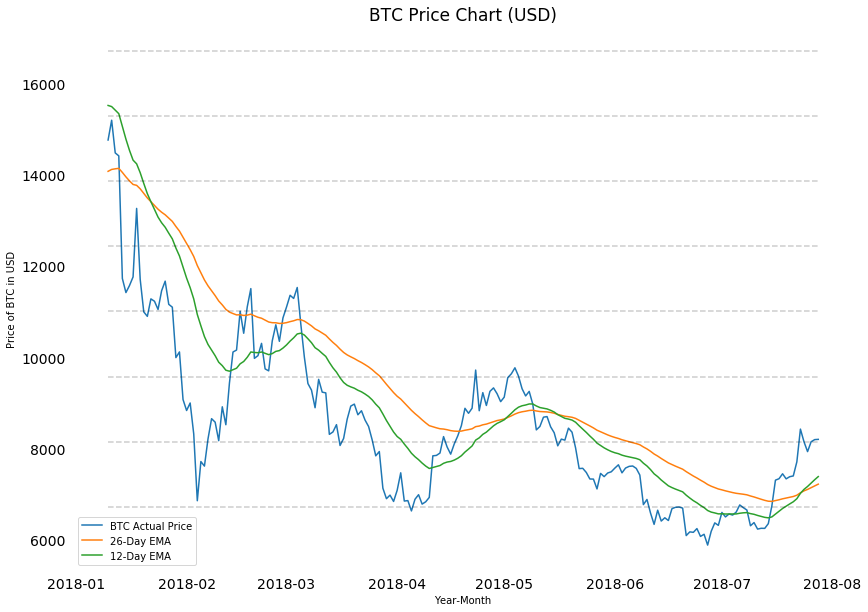

In [14]:
# Plot graph and save
plt.figure(figsize = (14, 10))

ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()

plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)

plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on") 

plt.title( coin_name + " Price Chart (USD)", fontsize = 17)
plt.plot(coin_new_srs)
plt.plot(day_26_ewm_new_srs)
plt.plot(day_12_ewm_new_srs)
plt.plot(coin_axis, "k--", alpha = 0.2)
plt.xlabel("Year-Month")
plt.ylabel("Price of " + coin_name + " in USD")
plt.legend([ coin_name + " Actual Price","26-Day EMA","12-Day EMA"])

plt.savefig( coin_name_file + "_price_ewma_chart_1.png")
plt.show()
plt.close()

In [15]:
# For Axis Lines for smaller graph
axis_b = np.min(macd_new_srs) * 1.1
axis_t = np.max(macd_new_srs) * 1.1
axis_l = axis_t - axis_b
axis_int = axis_l/6

coin_axis = coin.assign(y1 = lambda x: 0)
coin_axis = coin_axis.assign(y2 = lambda x: 0)
coin_axis = coin_axis.assign(y3 = lambda x: 1 * axis_int)
coin_axis = coin_axis.assign(y4 = lambda x: 2 * axis_int)
coin_axis = coin_axis.assign(y5 = lambda x: 3 * axis_int)
coin_axis = coin_axis.assign(y6 = lambda x: -1 * axis_int)
coin_axis = coin_axis.assign(y7 = lambda x: -2 * axis_int)
coin_axis = coin_axis.assign(y8 = lambda x: -3 * axis_int)

coin_axis = coin_axis.loc[:, ["y1","y2","y3","y4","y5","y6","y7","y8"]]

coin_price_timeindex2 = datetime_generator(coin_axis, start_date)
coin_axis = coin_axis.set_index(coin_price_timeindex2)
coin_axis = coin_axis[-200:]

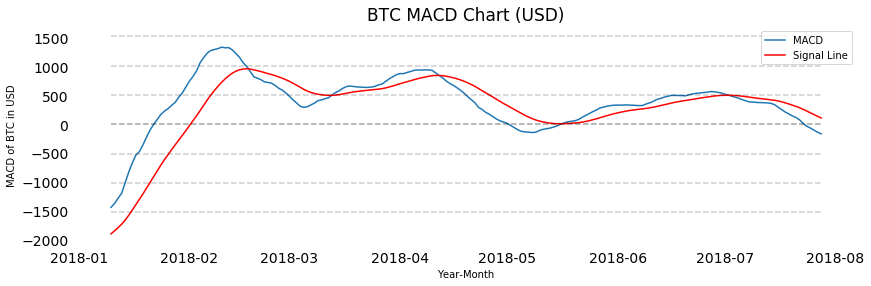

In [16]:
# Plot graph and save
plt.figure(figsize = (14, 4))

ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)

plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on") 

plt.title( coin_name + " MACD Chart (USD)", fontsize = 17)
plt.plot(macd_new_srs)
plt.plot(sig_new_srs, "r")
plt.plot(coin_axis, "k--", alpha = 0.2)
plt.xlabel("Year-Month")
plt.ylabel("MACD of " + coin_name + " in USD")
plt.legend(["MACD","Signal Line"])

plt.savefig( coin_name_file + "_price_ewma_chart_2.png")
plt.show()
plt.close()

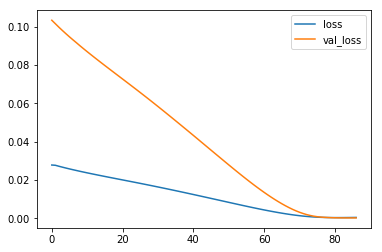

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["loss","val_loss"])

In [18]:
(((coin_price[:int((len(coin_price) * 0.05))] - predicted_srs[:int((len(predicted_srs) * 0.05))])**2).mean())

131690.56247429122

In [19]:
NVV = (coin["market_cap"]/coin["total_volume"])
NVV_s = pd.Series(NVV)

# Convert to series for plotting (NVV)
NVV_df = pd.DataFrame(NVV_s)
NVV_srs = NVV_df.values
NVV_srs_timeindex = datetime_generator(NVV_srs, start_date)
NVV_new_srs = cut_reset_series_with_0_and_date(NVV_df, 200, NVV_srs_timeindex)

In [20]:
# For Axis Lines for smaller graph
axis_b = 0
axis_t = np.max(NVV[-200:]) * 1.1
axis_l = axis_t - axis_b
axis_int = axis_l/6

coin_axis = coin.assign(y1 = lambda x: 0)
coin_axis = coin_axis.assign(y2 = lambda x: 0)
coin_axis = coin_axis.assign(y3 = lambda x: 1 * axis_int)
coin_axis = coin_axis.assign(y4 = lambda x: 2 * axis_int)
coin_axis = coin_axis.assign(y5 = lambda x: 3 * axis_int)
coin_axis = coin_axis.assign(y6 = lambda x: 4 * axis_int)
coin_axis = coin_axis.assign(y7 = lambda x: 5 * axis_int)
coin_axis = coin_axis.assign(y8 = lambda x: 6 * axis_int)

coin_axis = coin_axis.loc[:, ["y1","y2","y3","y4","y5","y6","y7","y8"]]

coin_price_timeindex2 = datetime_generator(coin_axis, start_date)
coin_axis = coin_axis.set_index(coin_price_timeindex2)
coin_axis = coin_axis[-200:]

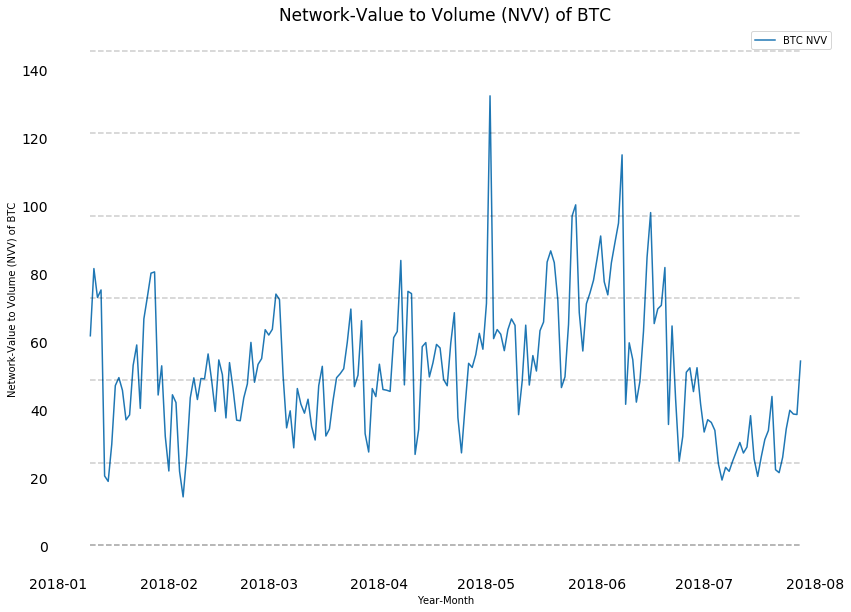

In [21]:
# Plot graph and save
plt.figure(figsize = (14, 10))

ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()

plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)

plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on") 

plt.title( "Network-Value to Volume (NVV) of " + coin_name, fontsize = 17)
plt.plot(NVV_new_srs)
plt.plot(coin_axis, "k--", alpha = 0.2)
plt.xlabel("Year-Month")
plt.ylabel("Network-Value to Volume (NVV) of " + coin_name)
plt.legend([ coin_name + " NVV"])

plt.savefig( coin_name_file + "_nvv_chart.png")
plt.show()
plt.close()

In [22]:
# For CSV (NVV and % Change in Price)
NVV_1D = NVV[len(NVV) - 1]
NVV_10D = NVV[len(NVV) - 11]
NVV_1M = NVV[len(NVV) - 31]
NVV_3M = NVV[len(NVV) - 91]
NVV_6M = NVV[len(NVV) - 183]
NVV_1Y = NVV[len(NVV) - 366]

Price_Change_10D = ((coin_price[len(coin_price) - 1] - coin_price[len(coin_price) - 11])/coin_price[len(coin_price) - 11]) * 100
Price_Change_1M = ((coin_price[len(coin_price) - 1] - coin_price[len(coin_price) - 31])/coin_price[len(coin_price) - 31]) * 100
Price_Change_3M = ((coin_price[len(coin_price) - 1] - coin_price[len(coin_price) - 91])/coin_price[len(coin_price) - 91]) * 100
Price_Change_6M = ((coin_price[len(coin_price) - 1] - coin_price[len(coin_price) - 183])/coin_price[len(coin_price) - 183]) * 100
Price_Change_1Y = ((coin_price[len(coin_price) - 1] - coin_price[len(coin_price) - 366])/coin_price[len(coin_price) - 366]) * 100

In [23]:
# Index Performance Check
index = pd.read_csv("c20-usd-max.csv")
index_change = index["price"].pct_change()
coin_change = coin["price"].pct_change()

print(index_change[-1:].values)
print(coin_change[-1:].values)

if coin_change[-1:].values > index_change[-1:].values:
    Index_comparison = "Outperform"
else:
    Index_comparison = "Underperform"
    
print(Index_comparison)

[-0.01609647]
[0.00066623]
Outperform


In [24]:
# CSV Output Constructor
columnheaders = combiners(coin_name)
indexheaders = combiners("Latest_Price", "Predicted_Price", "Indicator_Recommendation", "Index_Comparison", 
                         "MACD_Convergence_Indicator", "MACD_Signal_Indicator", "Technical_Score", 
                         "NVV_(Latest)", "NVV_(10-Day)", "Price_Change_(%)_(10-Day)", "NVV_(1-Month)", "Price_Change_(%)_(1-Month)", 
                         "NVV_(3-Month)", "Price_Change_(%)_(3-Month)", "NVV_(6-Month)", "Price_Change_(%)_(6-Month)", 
                         "NVV_(1-Year)", "Price_Change_(%)_(1-Year)")
data_ = combiners(coin_price[-1], predicted_new_srs[-1], recommendation(coin_price[-1], predicted_new_srs[-1], 0.01), Index_comparison, 
                  MACD_convergence_indicator, MACD_Signal_indicator, Technical_Score, 
                  NVV_1D, NVV_10D, Price_Change_10D, NVV_1M, Price_Change_1M, 
                  NVV_3M, Price_Change_3M, NVV_6M, Price_Change_6M, 
                  NVV_1Y, Price_Change_1Y)
run_csv = csv_generator(columnheaders, indexheaders, data_)